numpy is already installed.
pandas is already installed.
Installing pillow...
pillow has been installed.
torch is already installed.
torchvision is already installed.
timm is already installed.
torch-optimizer is already installed.
Installing scikit-learn...
scikit-learn has been installed.
matplotlib is already installed.
Using device: cuda
Number of classes: 15
Training dataset size: 6475
Validation dataset size: 362
Creating model: swin_base_patch4_window7_224
Initial backbone frozen for gradual unfreezing
Using RAdam + Lookahead optimizer
Using OneCycleLR scheduler

=== Epoch 1/50 ===
Image batch shape: torch.Size([32, 3, 224, 224])
Batch 20/203, Loss: 2.3629
Batch 40/203, Loss: 2.3446
Batch 60/203, Loss: 2.4562
Batch 80/203, Loss: 2.2047
Batch 100/203, Loss: 2.3383
Batch 120/203, Loss: 2.2803
Batch 140/203, Loss: 2.2480
Batch 160/203, Loss: 2.2076
Batch 180/203, Loss: 2.0127
Batch 200/203, Loss: 2.0598
Train Loss: 2.3133
  Val Loss: 1.9658, Val Acc: 0.2293
Saved new best model wit

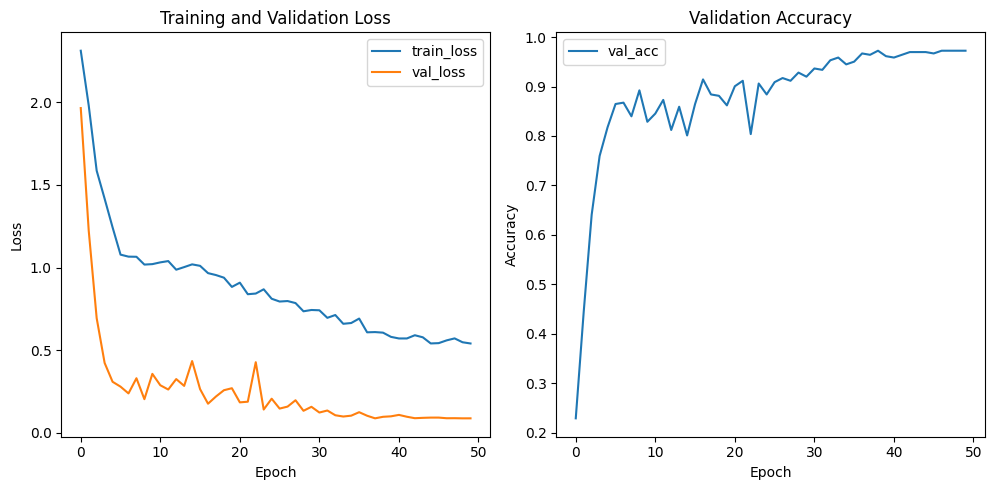

Training metrics plot saved to training_metrics.png
Best validation accuracy: 0.9724
Final model saved


In [1]:
import sys
import subprocess

required_packages = [
    'numpy',
    'pandas',  # for CSV saving
    'pillow',  # PIL
    'torch',
    'torchvision',
    'timm',
    'torch-optimizer',
    'scikit-learn',
    'matplotlib'
]

def install_package(package):
    print(f"Installing {package}...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Install missing packages
for package in required_packages:
    try:
        __import__(package.replace('-', '_'))
        print(f"{package} is already installed.")
    except ImportError:
        install_package(package)
        print(f"{package} has been installed.")

# Now import all needed packages
import os
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as transforms

import timm
from timm.data.auto_augment import rand_augment_transform
from timm.data.mixup import Mixup
import torch_optimizer as optim2

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


def seed_everything(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)


class GeoDataset(Dataset):
    """
    Returns (img, label, idx) for hard example mining
    """
    def __init__(self, df, img_dir, transform):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, img_name)
        try:
            img = Image.open(img_path).convert('RGB')
            img = self.transform(img)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            img = torch.zeros(3, 224, 224)
        label = int(self.df.loc[idx, 'Region_ID']) - 1
        return img, label, idx


class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce = nn.functional.cross_entropy(inputs, targets, reduction='none')
        p_t = torch.exp(-ce)
        loss = (1 - p_t) ** self.gamma * ce
        if self.alpha is not None:
            at = self.alpha.gather(0, targets)
            loss = at * loss
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss


if __name__ == '__main__':
    # 1. Repro & device
    seed_everything(42)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Define data paths - update these to your actual paths
    DATA_ROOT = '/kaggle/input'  # Change this to your data directory
    TRAIN_CSV = os.path.join(DATA_ROOT, 'labelcsv/labels_train_updated.csv')
    VAL_CSV   = os.path.join(DATA_ROOT, 'labelcsv/labels_val_updated.csv')
    TRAIN_IMG_DIR = os.path.join(DATA_ROOT, 'images/images/images_train')
    VAL_IMG_DIR   = os.path.join(DATA_ROOT, 'images/images/images_val')
    for path in [TRAIN_CSV, VAL_CSV, TRAIN_IMG_DIR, VAL_IMG_DIR]:
        if not os.path.exists(path):
            print(f"WARNING: Path {path} does not exist. Please update the path.")

    # 2. Load & clean labels
    try:
        train_df = pd.read_csv(TRAIN_CSV).dropna(subset=['Region_ID']).reset_index(drop=True)
        val_df   = pd.read_csv(VAL_CSV).dropna(subset=['Region_ID']).reset_index(drop=True)
        train_df['Region_ID'] = train_df['Region_ID'].astype(int)
        val_df['Region_ID']   = val_df['Region_ID'].astype(int)
        num_classes = train_df['Region_ID'].nunique()
        print(f"Number of classes: {num_classes}")
    except Exception as e:
        print(f"Error loading CSV files: {e}")
        sys.exit(1)

    # 3. Transforms
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        rand_augment_transform(config_str='rand-m9-mstd0.5-inc1', hparams={'translate_const': 100}),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.1)
    ])
    val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # 4. Dataset + Sampler
    train_ds = GeoDataset(train_df, TRAIN_IMG_DIR, train_transform)
    val_ds   = GeoDataset(val_df,   VAL_IMG_DIR,   val_transform)
    print(f"Training dataset size: {len(train_ds)}")
    print(f"Validation dataset size: {len(val_ds)}")

    sample_weights = np.ones(len(train_ds), dtype=np.float32)
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(train_ds), replacement=True)

    # 5. MixUp & CutMix
    mixup_fn = Mixup(
        mixup_alpha=0.8, cutmix_alpha=1.0,
        prob=1.0, switch_prob=0.5,
        mode='batch', label_smoothing=0.1,
        num_classes=num_classes)

    # 6. Model
    try:
        print("Creating model: swin_base_patch4_window7_224")
        model = timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=num_classes)
        model.to(device)
    except Exception:
        print("Fallback to efficientnet_b0")
        model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=num_classes)
        model.to(device)

    # 7. Freeze backbone
    freeze_epochs = 5
    for name, param in model.named_parameters():
        if 'head' not in name and 'fc' not in name:
            param.requires_grad = False
    print("Initial backbone frozen for gradual unfreezing")

    # 8. Loss & optimizer
    criterion = FocalLoss(gamma=2.0, alpha=None, reduction='mean')
    try:
        head_params = [p for n,p in model.named_parameters() if ('head' in n or 'fc' in n) and p.requires_grad]
        backbone_params = [p for n,p in model.named_parameters() if p.requires_grad and 'head' not in n and 'fc' not in n]
        base_optimizer = optim2.RAdam([
            {'params': backbone_params, 'lr': 1e-4},
            {'params': head_params,     'lr': 1e-3}
        ], weight_decay=1e-2)
        optimizer = optim2.Lookahead(base_optimizer, k=5, alpha=0.5)
        print("Using RAdam + Lookahead optimizer")
    except Exception:
        optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
        print("Falling back to AdamW optimizer")

    # 9. Scheduler
    batch_size = 32
    steps_per_epoch = len(train_ds) // batch_size + 1
    try:
        if isinstance(optimizer, optim2.Lookahead):
            scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=[1e-4,1e-3], steps_per_epoch=steps_per_epoch, epochs=50)
        else:
            scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=steps_per_epoch, epochs=50)
        print("Using OneCycleLR scheduler")
    except Exception:
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
        print("Falling back to ReduceLROnPlateau scheduler")

    # 10. DataLoaders
    try:
        train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=sampler, num_workers=4)
        val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=4)
    except Exception:
        train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=sampler, num_workers=0)
        val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=0)

    os.makedirs('models', exist_ok=True)

    # 11. Training
    num_epochs = 50
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = 0.0

    try:
        for epoch in range(1, num_epochs+1):
            print(f"\n=== Epoch {epoch}/{num_epochs} ===")
            model.train()
            if epoch == freeze_epochs + 1:
                for param in model.parameters(): param.requires_grad = True
                print("Unfroze all layers")

            per_sample_losses = np.zeros(len(train_ds), dtype=np.float32)
            running_loss = 0.0
            preds, trues = [], []

            for i, (imgs, labels, indices) in enumerate(train_loader):
                if i == 0:
                    print(f"Image batch shape: {imgs.shape}")
                imgs, labels = imgs.to(device), labels.to(device)
                try:
                    imgs, labels = mixup_fn(imgs, labels)
                except Exception:
                    pass
                optimizer.zero_grad()
                logits = model(imgs)
                loss = criterion(logits, labels)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                if isinstance(scheduler, optim.lr_scheduler.OneCycleLR): scheduler.step()

                # store per-sample CE losses
                try:
                    batch_losses = nn.functional.cross_entropy(logits, labels, reduction='none')
                    for j, idx in enumerate(indices):
                        if idx < len(per_sample_losses):
                            per_sample_losses[idx] = batch_losses[j].item()
                except Exception:
                    pass

                running_loss += loss.item() * imgs.size(0)
                if (i+1) % 20 == 0:
                    print(f"Batch {i+1}/{len(train_loader)}, Loss: {loss.item():.4f}")

            train_loss = running_loss / len(train_ds)
            history['train_loss'].append(train_loss)

            # validation
            model.eval()
            val_running, v_preds, v_trues = 0.0, [], []
            with torch.no_grad():
                for imgs, labels, _ in val_loader:
                    imgs, labels = imgs.to(device), labels.to(device)
                    logits = model(imgs)
                    loss = criterion(logits, labels)
                    val_running += loss.item() * imgs.size(0)
                    v_preds.extend(logits.argmax(1).cpu().numpy())
                    v_trues.extend(labels.cpu().numpy())
            val_loss = val_running / len(val_ds)
            val_acc  = accuracy_score(v_trues, v_preds)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)

            print(f"Train Loss: {train_loss:.4f}")
            print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
            if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)

            # Update sampler for hard example mining
            if np.sum(per_sample_losses) > 0:
                norm_losses = np.clip(per_sample_losses / np.mean(per_sample_losses), 0.5, 5.0)
                sample_weights = norm_losses
            else:
                sample_weights = np.ones(len(train_ds), dtype=np.float32)
            sampler = WeightedRandomSampler(sample_weights, num_samples=len(train_ds), replacement=True)
            try:
                train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=sampler, num_workers=4)
            except Exception:
                train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=sampler, num_workers=0)

            # Save best model + predictions
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), os.path.join('models', 'best_model.pth'))
                print(f"Saved new best model with validation accuracy: {val_acc:.4f}")

                # save out predicted labels for each validation example
                pred_df = pd.DataFrame({
                    'id': list(range(len(v_preds))),
                    'Region_ID': [p + 1 for p in v_preds]
                })
                csv_name = f"prediction_{val_acc:.4f}.csv"
                csv_path = os.path.join('models', csv_name)
                pred_df.to_csv(csv_path, index=False)
                print(f"Saved predictions to {csv_path}")

            # checkpoint every 5 epochs
            if epoch % 5 == 0:
                torch.save(model.state_dict(), os.path.join('models', f'model_epoch_{epoch}.pth'))
                print(f"Saved checkpoint at epoch {epoch}")

            # early stopping
            if epoch > 10 and val_loss > max(history['val_loss'][-5:]):
                print("Early stopping due to validation loss increasing")
                break

        # 13. Plot metrics
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.plot(history['train_loss'], label='train_loss')
        plt.plot(history['val_loss'], label='val_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(history['val_acc'], label='val_acc')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Validation Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.savefig('training_metrics.png')
        plt.show()
        print("Training metrics plot saved to training_metrics.png")
        print(f"Best validation accuracy: {best_val_acc:.4f}")

    except Exception as e:
        print(f"Error during training: {e}")
        import traceback; traceback.print_exc()
        torch.save(model.state_dict(), os.path.join('models', 'error_recovery_model.pth'))
        print("Model saved for error recovery")

    finally:
        torch.save(model.state_dict(), os.path.join('models', 'final_model.pth'))
        print("Final model saved")
